In this notebook I build a simple neural network, having a single hidden layer. Next, I compare this model for its classification accuracy to a boilerplate logistic regression. 

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation

This notebook was inspired by Andrew Ng's Deep Learning Specialization tutorial on Coursera 

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as datasets
import sklearn.linear_model

import copy as copy 

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

np.random.seed(42) # set a seed so that the results are consistent

## Dataset ##

Code to make spirals is adapted from: 

http://cs231n.github.io/neural-networks-case-study/

In [2]:
N = 400 # number of points per class
D = 2 # dimensionality 
K = 2 # number of spokes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
Y = np.zeros(N*K, dtype='int') # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0, 1, N) # radius
    t = np.linspace(j*4.2, (j+1)*4.2, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = (0 if j % 2 == 0 else 1)

X = copy.deepcopy(X.T)
Y = copy.deepcopy(Y.reshape(-1,1).T)

Text(0.5, 1.0, 'Visualize data')

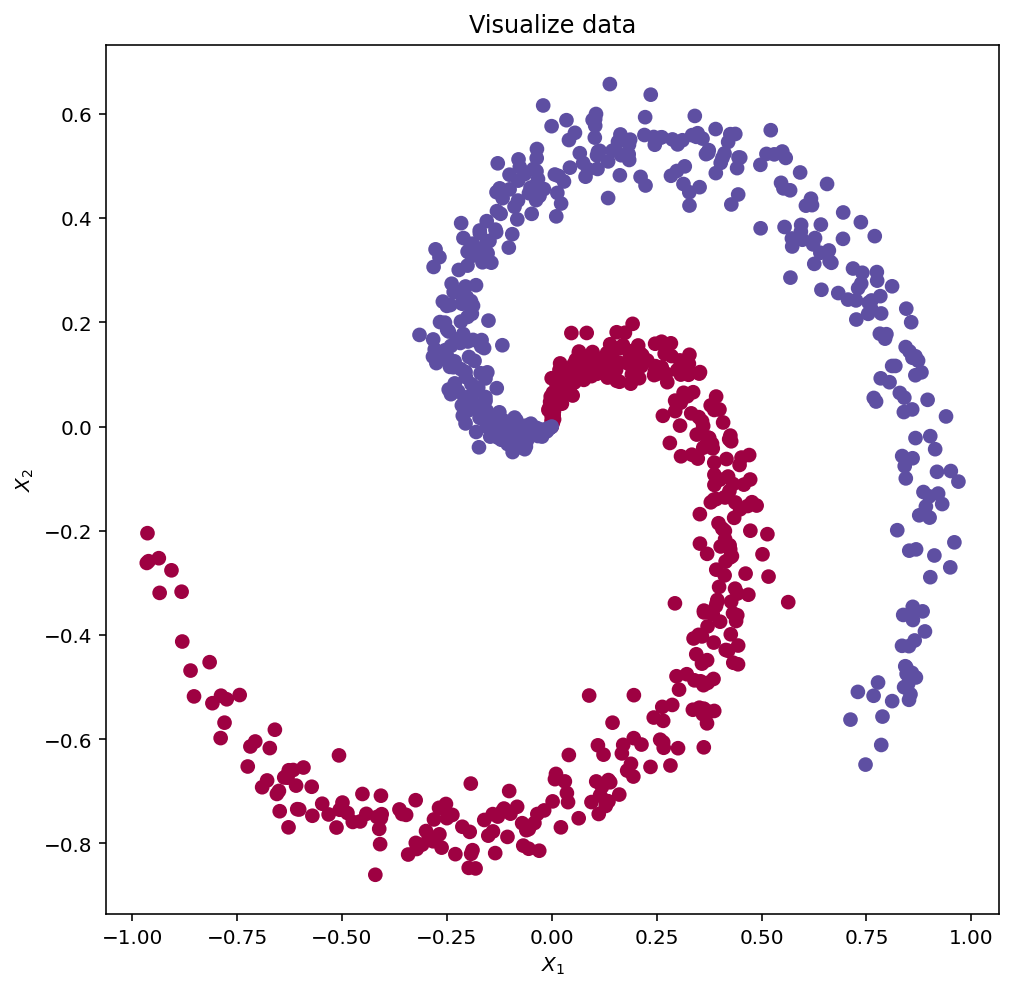

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
    
# lets visualize the data:
ax.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral)
ax.set_xlabel('$X_1$')
ax.set_ylabel('$X_2$')
ax.set_title('Visualize data')

In [4]:
shape_X = X.shape
shape_Y = Y.shape

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))

The shape of X is: (2, 800)
The shape of Y is: (1, 800)


## Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [5]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegression();
clf.fit(X.T, Y.ravel());

Convenience function to plot a decision boundary for the classification model 

In [6]:
def plot_decision_boundary(func, x_input, y_input):
    xx_1, xx_2 = np.mgrid[np.min(x_input[:,0]):np.max(x_input[:,0]):.01, np.min(x_input[:,1]):np.max(x_input[:,1]):.01]
    grid = np.c_[xx_1.ravel(), xx_2.ravel()]
    y_pred_grid = func(grid).reshape(xx_1.shape)
    y_pred = func(x_input)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    contour = ax.contourf(xx_1, xx_2, y_pred_grid, alpha=0.7, cmap="Spectral")
    ax.scatter(x_input[:,0], x_input[:, 1], c=y_pred, s=50, cmap="Spectral", edgecolor="white", linewidth=1)
    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
    ax.set(aspect='equal', 
           xlim=(np.min(x_input[:,0]), np.max(x_input[:,0])), ylim=(np.min(x_input[:,1]),np.max(x_input[:,1])),
           xlabel="$X_1$", ylabel="$X_2$")

Text(0.5, 1.0, 'Logistic Regression')

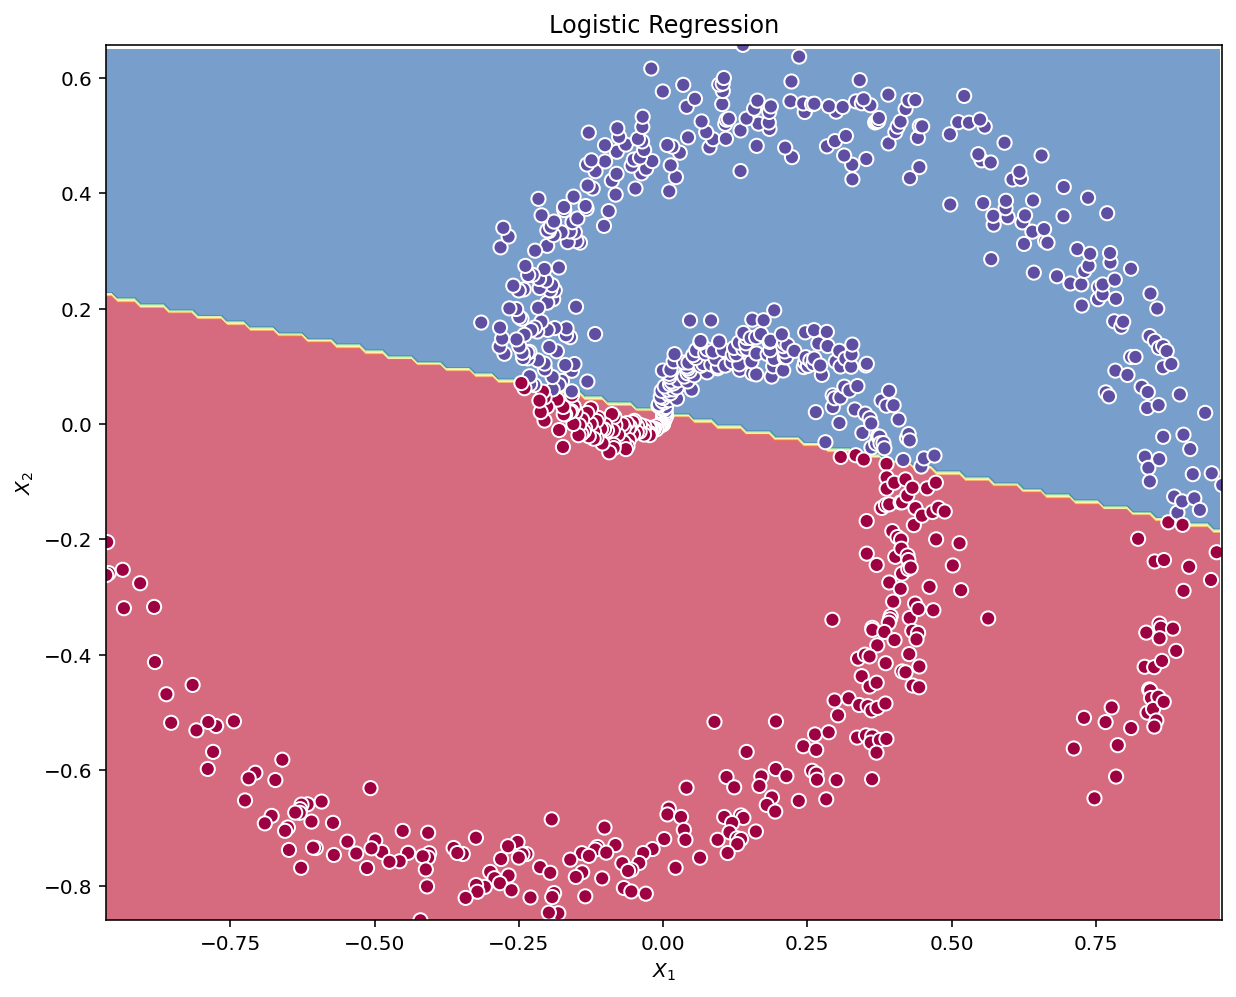

In [7]:
plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)
plt.title("Logistic Regression")

In [8]:
# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y, LR_predictions) + np.dot(1-Y, 1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 66 % (percentage of correctly labelled datapoints)


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better.

## Neural Network model

Logistic regression did not work well on the dataset. Let's train a Neural Network with a single hidden layer and see if it does any better.

**Here is basic framework for the model**:
![](NN_classification/classification_kiank.png "Image courtesy: Deep Learning Specialization (deeplearning.ai)")

**Mathematically**:

For one example $x^{(i)}$:

$$
z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}
$$ 

$$
a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}
$$

$$
z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}
$$

$$
\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}
$$

$$
y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}
$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 

$$
J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}
$$

**The general methodology to build a Neural Network is to:**
1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters (gradient descent)

### Defining the neural network structure ####

Define three variables:

    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

In [9]:
def layer_sizes(X, Y, n_h=4):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """

    n_x = X.shape[0] # size of input layer
    n_h = n_h
    n_y = Y.reshape(-1,1).T.shape[0] # size of output layer

    return (n_x, n_h, n_y)

In [10]:
(n_x, n_h, n_y) = layer_sizes(X, Y)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 2
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 1


### Initialize the model's parameters ####

- Initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- Initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [11]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(42) # we set up a seed so that your output matches ours although the initialization is random.

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h,1))
    
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### Forward-pass ####

Implement `forward_propagation()`:

1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [12]:
def sigmoid(x):
    z = 1/(1 + np.exp(-x))
    return z

In [13]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    ### END CODE HERE ###
    
    # Implement Forward Propagation
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

## Loss function ##

Compute the cost function as follows:

$$
J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}
$$

In [14]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.dot(Y,np.log(A2).T) + np.dot((1-Y),np.log((1-A2)).T)
    cost = -logprobs/m

    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

## Back-propogation ##

Using the cache computed during forward propagation, now implement backward propagation.

$$
\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})
$$

$$
\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T}
$$

$$
\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}
$$

$$
\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2})
$$

$$
\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T
$$

$$
\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}
$$

- $*$ denotes elementwise multiplication.
- Gradients for each later: 
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$

In [15]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']

    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']

    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2,A1.T)
    db2 = (1/m) * np.sum(dZ2,axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

**General gradient descent formalism**: 
$$ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$$

where: $\alpha$ is the learning rate and $\theta$ represents a parameter.

In [16]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']

    # Update rule for each parameter
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

## Integrate previous parts `nn_model()` ##

In [17]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(42)
    n_x, n_h, n_y = layer_sizes(X, Y, n_h=n_h)
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)

    # Loop (gradient descent)
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)

        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

### Predictions

Use the model to predict: `predict()`.

Use forward propagation to predict results.

predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  


In [18]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    threshold = 0.5 
    predictions = (A2 > threshold)
    
    return predictions

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

In [19]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.693141
Cost after iteration 1000: 0.052671
Cost after iteration 2000: 0.040765
Cost after iteration 3000: 0.032499
Cost after iteration 4000: 0.027457
Cost after iteration 5000: 0.023722
Cost after iteration 6000: 0.020082
Cost after iteration 7000: 0.016282
Cost after iteration 8000: 0.013001
Cost after iteration 9000: 0.010872


In [20]:
def plot_decision_boundary_NN(func, x_input, y_input, ax=None):
    xx_1, xx_2 = np.mgrid[np.min(x_input[:,0]):np.max(x_input[:,0]):.01, np.min(x_input[:,1]):np.max(x_input[:,1]):.01]
    grid = np.c_[xx_1.ravel(), xx_2.ravel()].T
    y_pred_grid = func(grid).reshape(xx_1.shape)
    y_pred = func(x_input.T)
    
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        
    contour = ax.contourf(xx_1, xx_2, y_pred_grid, alpha=0.7, cmap="Spectral")
    ax.scatter(x_input[:,0], x_input[:, 1], c=y_pred, s=50, cmap="Spectral", edgecolor="white", linewidth=1)
    
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
    ax.set(aspect='equal', 
           xlim=(np.min(x_input[:,0]), np.max(x_input[:,0])), ylim=(np.min(x_input[:,1]),np.max(x_input[:,1])),
           xlabel="$X_1$", ylabel="$X_2$")
    return ax

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

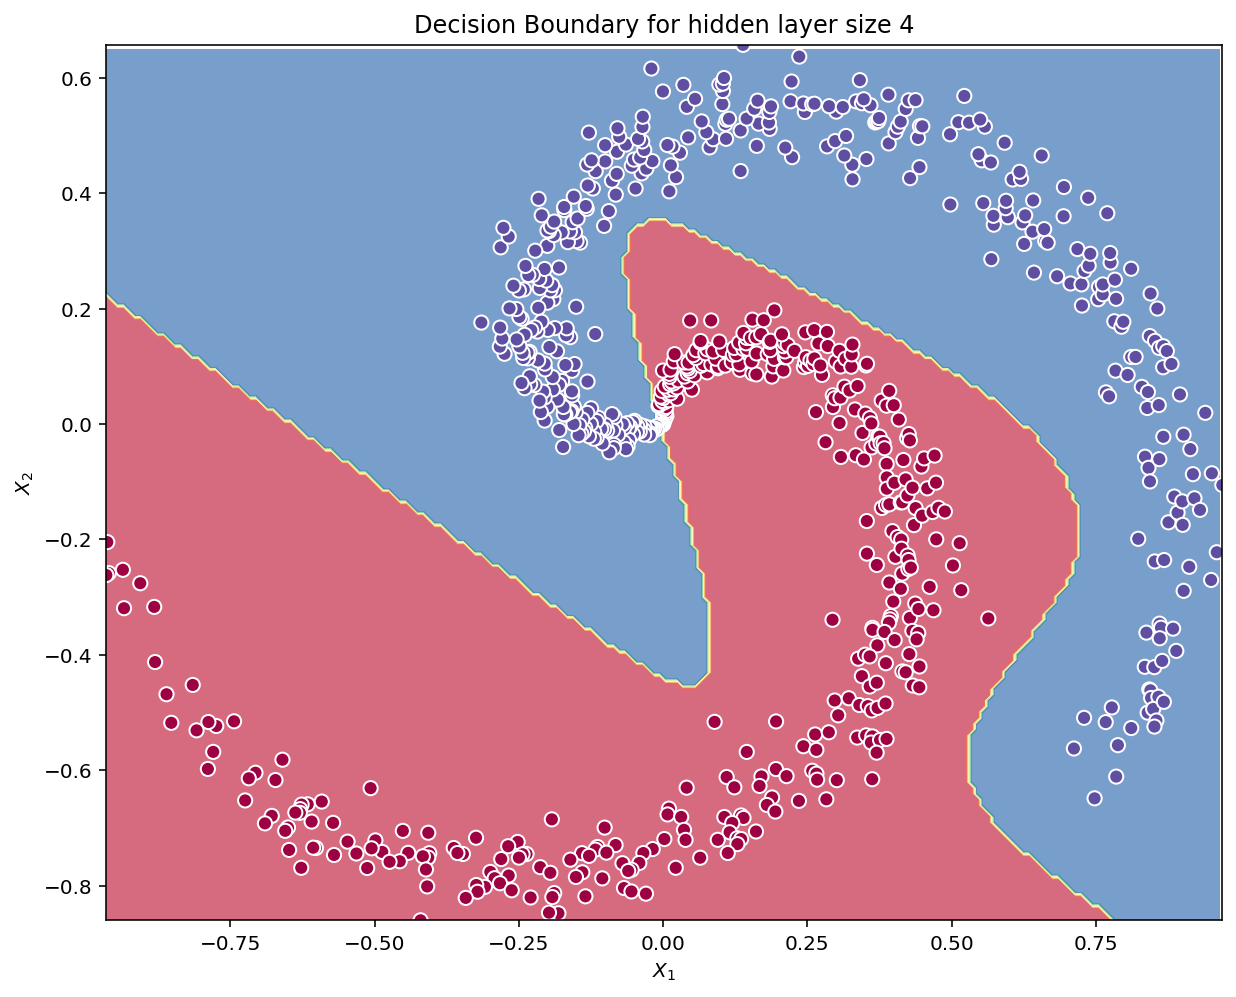

In [21]:
# Plot the decision boundary
plot_decision_boundary_NN(lambda x: predict(parameters, x), X.T, Y.T)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [22]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 99%


Accuracy is really high compared to Logistic Regression. The model has spirals! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

### Tuning hidden layer size ###
Run the following code to observe different behaviors of the model for various hidden layer sizes.

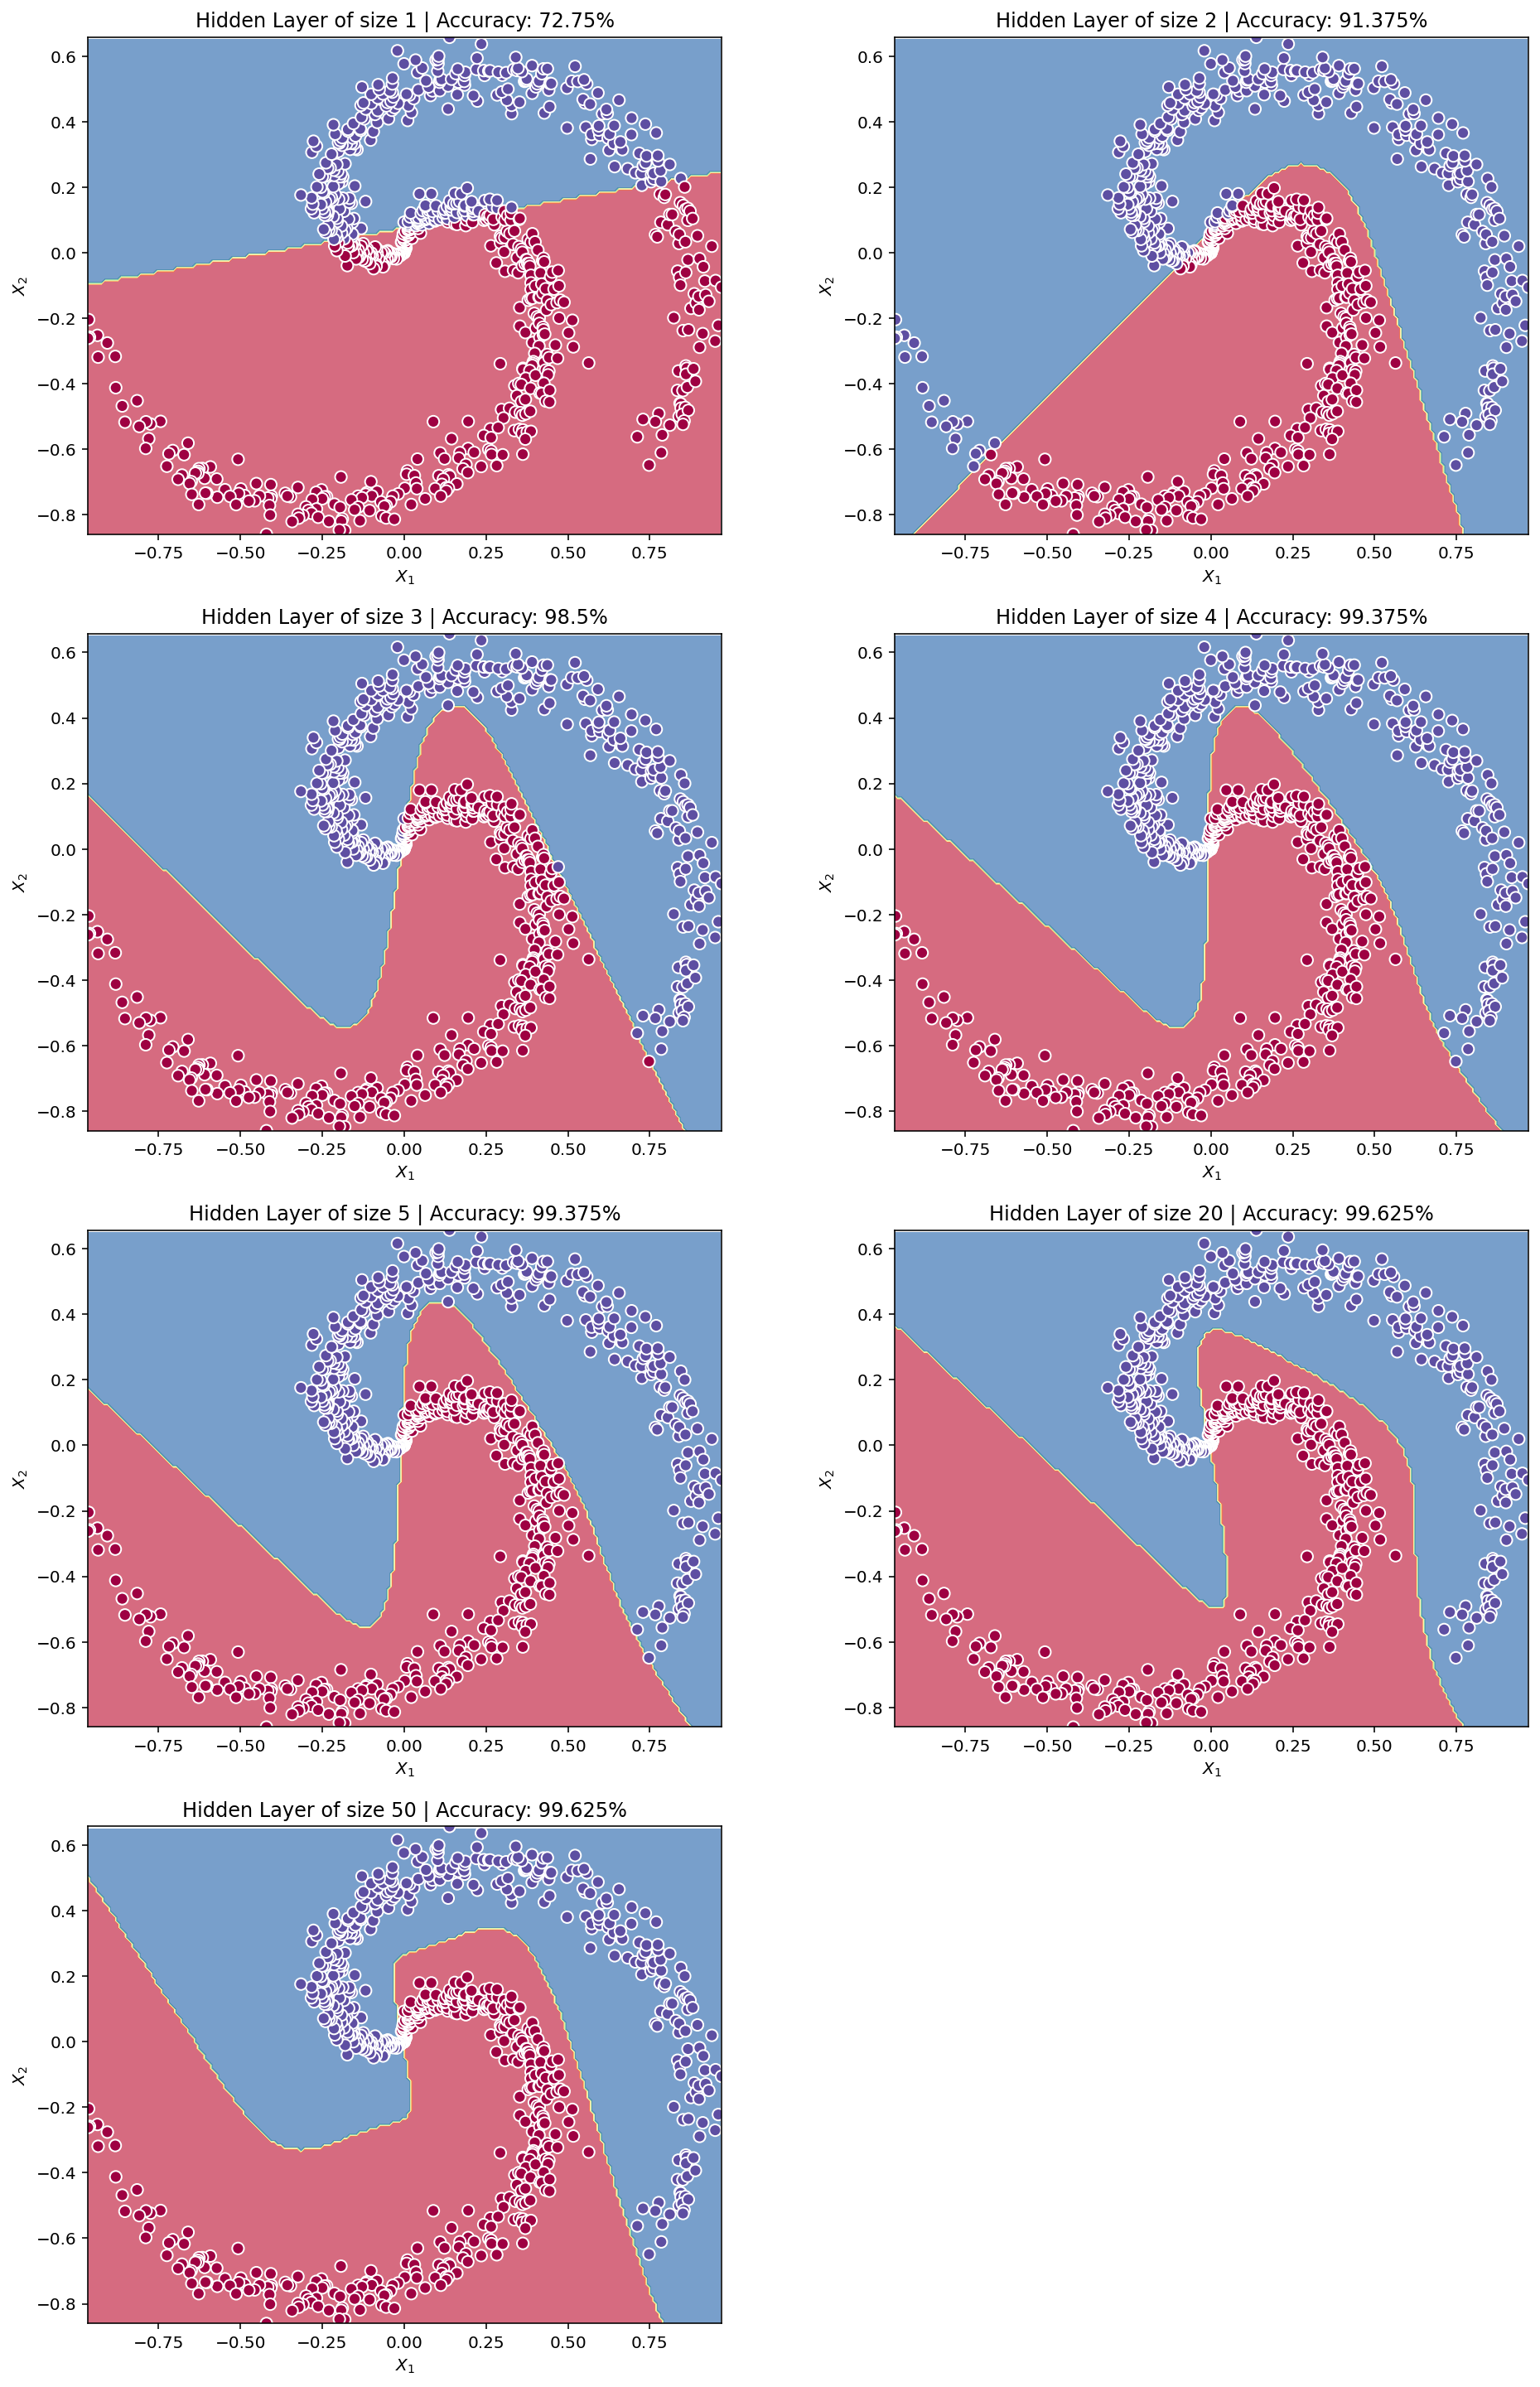

In [23]:
# This may take about 2 minutes to run
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    ax = plt.subplot(5, 2,i+1)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary_NN(lambda x: predict(parameters, x), X.T, Y.T, ax)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    ax.title.set_text('Hidden Layer of size {} | Accuracy: {}%'.format(n_h, accuracy))

### Reference: ###
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/